In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../Task 1/')
from efficient_apriori import apriori
from improved_apriori import Improved_Apriori
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../Task 2/dataset/final_animedataset.csv')
data = data[['username', 'title']]
data = data.groupby('username')['title'].apply(list)
data = data.to_dict()

In [3]:
# Step 2: Frequent Itemset Generation
# Use the apriori algorithm to generate frequent itemsets
apriori = Improved_Apriori(data, min_support=0.4, min_confidence=1)
frequent_itemsets = apriori.apriori()
frequent_itemsets

100%|██████████| 78/78 [00:01<00:00, 47.42it/s]
0it [00:00, ?it/s]


{1: {('Angel Beats!',): 65303,
  ('Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.',): 49456,
  ('Another',): 51658,
  ('Ao no Exorcist',): 53028,
  ('Bakemonogatari',): 57273,
  ('Bleach',): 63861,
  ('Byousoku 5 Centimeter',): 47041,
  ('Clannad',): 63023,
  ('Clannad: After Story',): 50104,
  ('Code Geass: Hangyaku no Lelouch',): 71414,
  ('Code Geass: Hangyaku no Lelouch R2',): 58654,
  ('Cowboy Bebop',): 51706,
  ('Darker than Black: Kuro no Keiyakusha',): 51982,
  ('Death Note',): 85642,
  ('Durarara!!',): 59267,
  ('Elfen Lied',): 68075,
  ('Fairy Tail',): 53143,
  ('Fate/stay night',): 48914,
  ('Fullmetal Alchemist',): 61241,
  ('Fullmetal Alchemist: Brotherhood',): 67132,
  ('Highschool of the Dead',): 55774,
  ('Higurashi no Naku Koro ni',): 49684,
  ('K-On!',): 50388,
  ('Mahou Shoujo Madoka★Magica',): 48549,
  ('Mirai Nikki (TV)',): 57010,
  ('Naruto',): 66343,
  ('Naruto: Shippuuden',): 53626,
  ('Neon Genesis Evangelion',): 52984,
  ('No Game No Life',): 48171,


In [4]:
# Create a binary matrix
# Flatten the dictionary into a list of itemsets
itemsets = [itemset for level in frequent_itemsets.values() for itemset in level.keys()]

# Transactions 
transactions = list(data.values())

binary_matrix = pd.DataFrame(0, index=range(len(transactions)), columns=itemsets)

# Fill in the binary matrix
for i, transaction in enumerate(transactions):
    for itemset in itemsets:
        if set(itemset).issubset(transaction):
            binary_matrix.at[i, itemset] = 1  # Use 'at' instead of 'loc' for scalar indexing

binary_matrix


,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Naruto, Naruto: Shippuuden)","(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)"
0,0,0,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,1,0,0,1,0,0,...,1,1,1,1,1,1,0,0,0,1
4,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
116120,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,1,0,0
116121,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0,1,1
116122,1,1,1,0,0,0,0,1,1,1,...,0,1,1,0,1,0,0,0,0,0


In [5]:
def tf_idf_normalize(binary_matrix,itemset_frequencies):
    TF_IDF_matrix = binary_matrix.copy()
    # For each column in the binary matrix
    for column in TF_IDF_matrix.columns:
        level = len(column)

        # Get the frequency of the itemset from the dictionary
        frequency = itemset_frequencies[level][column]

        # Calculate IDF
        IDF = np.log(len(TF_IDF_matrix)/frequency)
        TF_IDF_matrix[column] = TF_IDF_matrix[column] * IDF


    return TF_IDF_matrix

from sklearn import metrics
def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index


In [6]:
TF_IDF_matrix = tf_idf_normalize(binary_matrix, frequent_itemsets)
TF_IDF_matrix

,"(Angel Beats!,)","(Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,)","(Another,)","(Ao no Exorcist,)","(Bakemonogatari,)","(Bleach,)","(Byousoku 5 Centimeter,)","(Clannad,)","(Clannad: After Story,)","(Code Geass: Hangyaku no Lelouch,)",...,"(Naruto, Naruto: Shippuuden)","(Shingeki no Kyojin, Steins;Gate)","(Shingeki no Kyojin, Sword Art Online)","(Shingeki no Kyojin, Toradora!)","(Steins;Gate, Sword Art Online)","(Sword Art Online, Toradora!)","(Code Geass: Hangyaku no Lelouch, Code Geass: Hangyaku no Lelouch R2, Death Note)","(Code Geass: Hangyaku no Lelouch, Death Note, Elfen Lied)","(Code Geass: Hangyaku no Lelouch, Death Note, Fullmetal Alchemist: Brotherhood)","(Death Note, Shingeki no Kyojin, Sword Art Online)"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.903639,0.611159,0.000000,0.486165,...,0.834231,0.000000,0.000000,0.000000,0.000000,0.000000,0.820874,0.912758,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.575621,0.000000,0.810014,0.783839,0.706829,0.00000,0.000000,0.611159,0.000000,0.000000,...,0.834231,0.847126,0.745854,0.898508,0.861085,0.871385,0.000000,0.000000,0.000000,0.890209
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.59795,0.903639,0.000000,0.000000,0.000000,...,0.834231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116119,0.000000,0.000000,0.000000,0.000000,0.000000,0.59795,0.903639,0.611159,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
116120,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.903639,0.000000,0.000000,0.486165,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.820874,0.912758,0.000000,0.000000
116121,0.575621,0.853575,0.810014,0.783839,0.706829,0.59795,0.000000,0.611159,0.840558,0.486165,...,0.834231,0.847126,0.745854,0.898508,0.861085,0.871385,0.820874,0.000000,0.890797,0.890209
116122,0.575621,0.853575,0.810014,0.000000,0.000000,0.00000,0.000000,0.611159,0.840558,0.486165,...,0.000000,0.847126,0.745854,0.000000,0.861085,0.000000,0.000000,0.000000,0.000000,0.000000


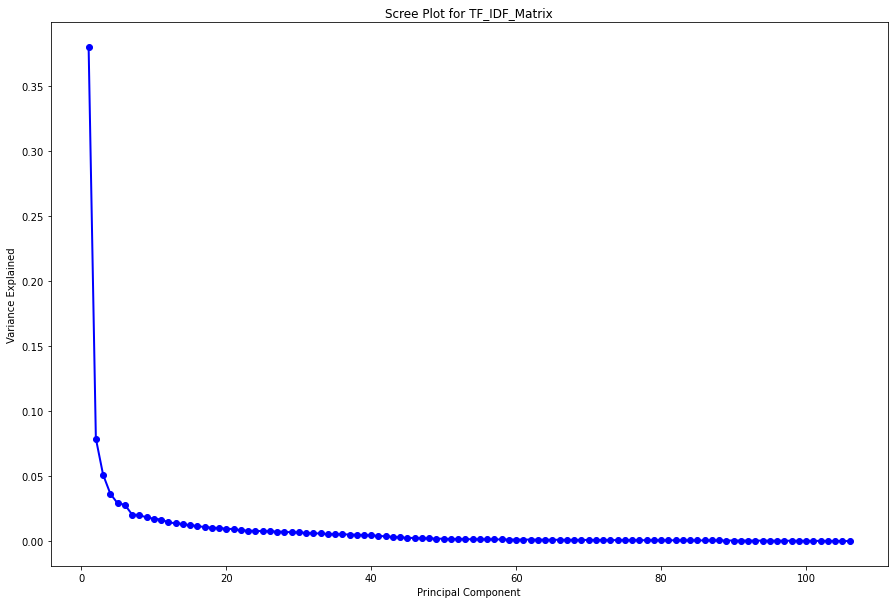

In [7]:
pca = PCA(random_state=24).fit(TF_IDF_matrix)
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot for TF_IDF_Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [8]:
pca = PCA(n_components=4, random_state=42)
transformed_TF_IDF_data = pca.fit_transform(TF_IDF_matrix)

In [9]:
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(transformed_TF_IDF_data, quantile=0.2)
print("Estimated bandwidth:", bandwidth)

Estimated bandwidth: 2.285013659398217


In [10]:
ms = MeanShift(bandwidth=bandwidth)  
ms.fit(transformed_TF_IDF_data)
cluster_centers = ms.cluster_centers_
labels = ms.labels_

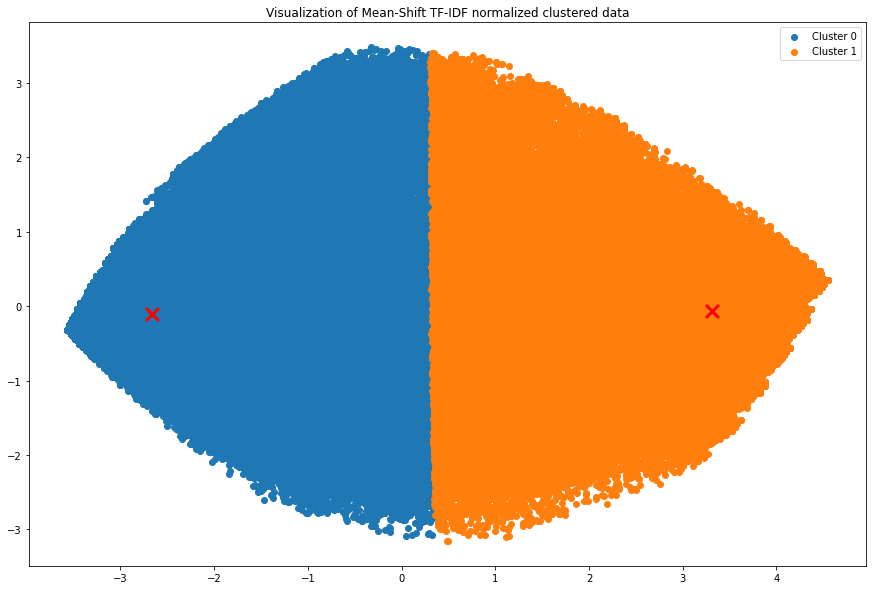

In [11]:
cluster_labels = ms.labels_
cluster_centers = ms.cluster_centers_
plt.figure(figsize=(15,10))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(transformed_TF_IDF_data[cluster_labels == i, 0], transformed_TF_IDF_data[cluster_labels == i, 1], label='Cluster '+str(i))
plt.legend()
plt.scatter(cluster_centers [:, 0], cluster_centers[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)
plt.title('Visualization of Mean-Shift TF-IDF normalized clustered data')
plt.show()

In [12]:
Meanshift_TF_IDF_silhouette, Meanshift_TF_IDF_davies_bouldin, Meanshift_TF_IDF_calinski_harabasz = evaluate_clustering(ms.labels_, transformed_TF_IDF_data)

print(f'Meanshift TF-IDF Normalized Silhouette score: {Meanshift_TF_IDF_silhouette}')
print(f'Meanshift TF-IDF Normalized Davies-Bouldin Index: {Meanshift_TF_IDF_davies_bouldin}')
print(f'Meanshift TF-IDF Normalized Calinski-Harabasz Index: {Meanshift_TF_IDF_calinski_harabasz}')

Meanshift TF-IDF Normalized Silhouette score: 0.4499692062892516
Meanshift TF-IDF Normalized Davies-Bouldin Index: 0.8842451220686465
Meanshift TF-IDF Normalized Calinski-Harabasz Index: 131779.96121143785
